In [12]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as cPickle
import xarray as xr

from driftutils import keep_in_domain as kid
from driftutils.utils import wrap_to_180
from plotutils.drift_map import dm_plot_driftmap_data
from plotutils.map_functions import plot_bathymetry

%matplotlib inline

## some useful functions

In [22]:
def load_data(fname, pdir=None):
    if pdir:
        pname = os.path.basename(fname).split('.')[0]
        pfile = os.path.join(pdir, pname + '.pickle')
        if os.path.exists(pfile):
            ds = load_pickle(pfile)
        else:
            with xr.load_dataset(fname) as ds:
                save_pickle(pfile, ds)
        return ds
    else:
        with xr.load_dataset(fname) as ds:
            return ds
    
def save_pickle(fname, data):
    #print('Creating ' + os.path.basename(fname))
    with open(fname, 'wb') as handle:
        cPickle.dump(data, handle)

def load_pickle(fname):
    #print('Loading ' + os.path.basename(fname))
    with open(fname, 'rb') as handle:
        loaded_data = cPickle.load(handle)
    return loaded_data

def create_savedir(path):
    try:
        os.makedirs(path, exist_ok = True)
    except OSError as error:
        pass

def set_up_map_plot(ax):
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'},
                 linewidth=2, color='gray', alpha=0.1, 
                 linestyle='-', zorder=1)
    return ax

def create_subplots_figure(nrows=1, ncols=1, map=False, fsize=None, ratio=1.5, axsize=6):
    """ratio is expected to be width/height so that a ratio of 2 will
    give a plot that is twice as wide as it is tall"""
    if not fsize:
        fsize = (ratio*(axsize*nrows), axsize*ncols)
    if map:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize,
                                subplot_kw={'projection': crs.PlateCarree()})
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize)
    return fig, axs.flatten()      

def plot_tracks_multi(ncfiles, savedir, labels, colors, pdir=None, axsize=None, etopo=None):
    
    fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True, axsize=axsize)
    ax = axs[0]
    set_up_map_plot(ax)
    
    for ncfile, lab, col in zip(ncfiles, labels, colors):
        ds = load_data(ncfile, pdir=pdir)
        for mr in ds.model_run.values:
            lons = ds.mod_lon[mr].values
            lats = ds.mod_lat[mr].values
            leglab = '_no_label_'
            if mr == 0:
                leglab = lab
            ax.plot(lons, lats, color=col, linestyle='-', linewidth=0.8, label=leglab)
            ax.plot(lons[0], lats[0], 'o', color='green', markersize=3)
    
    if etopo is not None:
        minlon, maxlon, minlat, maxlat = ax.get_extent(crs=crs.PlateCarree())
        plot_bbox = [minlon, maxlon, minlat, maxlat]
        plot_bathymetry(ax, plot_bbox, bathymetry_file=etopo, fig=fig)
        ax.set_extent(plot_bbox)
    
    plt.legend()
    plt.savefig(os.path.join(savedir, 'driftmap_comparison'))

## Plot the data

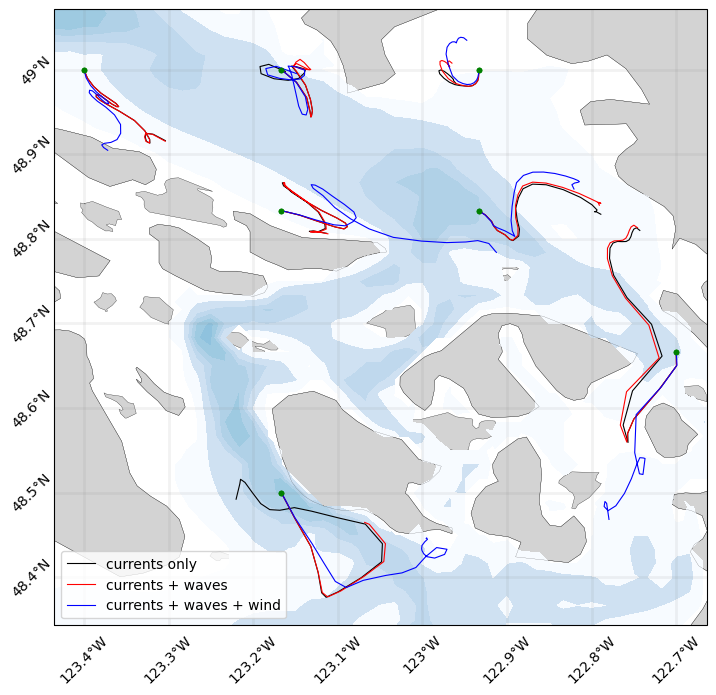

In [23]:
pdir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/input_data/SalishSea/data_converted/pickled_files/"
savedir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/OPPVF2F_2023/output/plots_checking_converted_salish_sea_od_output/"
currs_dir = "driftmap-sims_SalishSea_opendrift_20230323_currents"
currs_waves_dir = "driftmap-sims_SalishSea_opendrift_20230323_currents_waves"
currs_waves_wind_dir = "driftmap-sims_SalishSea_opendrift_20230323_currents_waves_wind"
etopo_file = "/home/sdfo000/sitestore7/opp_drift_fa3/software/misc_files/ETOPO1_Bed_g_gmt4.grd"

labels = ['currents only', 'currents + waves', 'currents + waves + wind'] 
dirs = [currs_dir, currs_waves_dir, currs_waves_wind_dir] 
colors = ['black', 'red', 'blue']
dirstr = ('/gpfs/fs7/dfo/dpnm/jeh326/projects/output_general_dwt_tests/{}/output/salishsea_od_2023021800_P1D.nc')
outncs = [dirstr.format(expstr) for expstr in dirs]

## make a simple map plot
plot_tracks_multi(outncs, savedir, labels, colors, axsize=8, etopo=etopo_file)